In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import interp1d, UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE_path = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'
sim_dCCE = np.loadtxt(sim_dCCE_path, delimiter=',').T

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

### tanz(Ep/En)
def eratio_to_tandepth(eratio, ae_over_ah, b, c):
    e_cce = (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
    h_cce = (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])
    tandepth = UnivariateSpline(ae_over_ah*(e_cce/h_cce), np.tan(np.pi*((sim_dCCE[0]/np.max(sim_depth)) - 0.5)), ext=3)(eratio)
    return tandepth

def eratio_to_depth(eratio, ae_over_ah, b, c):
    e_cce = (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
    h_cce = (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])
    depth = UnivariateSpline(ae_over_ah*(e_cce/h_cce), sim_dCCE[0], ext=3)(eratio)
    return depth

def depth_to_eratio(depth, ae_over_ah, b, c):
    e_cce = (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
    h_cce = (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])
    eratio = UnivariateSpline(sim_dCCE[0], ae_over_ah*(e_cce/h_cce))(depth)
    return eratio

### Tau(tanz)
tandepth_to_ctd = UnivariateSpline(np.tan(np.pi*((sim_depth/np.max(sim_depth)) - 0.5)), sim_ctd, ext=3)

### Tau_obs(Ep/En)
def eratio_to_ctd(eratio, ae_over_ah, b, c):
    tandepth = eratio_to_tandepth(eratio, ae_over_ah, b, c)
    # depth[depth<np.min(sim_depth)] = np.min(sim_depth)
    # depth[depth>np.max(sim_depth)] = np.max(sim_depth)
    return tandepth_to_ctd(tandepth)

p0 = [662.411/662.114, 1.326, 0.547]

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

21.7 +/- 1.9
19.3 +/- 1.7


/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Look at all Cs137 data prior to Loma Linda

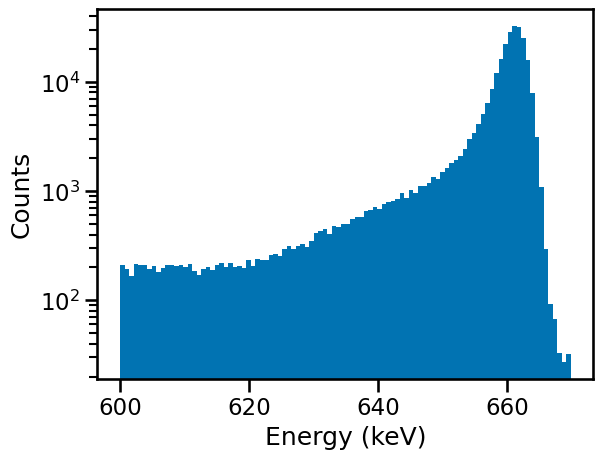

FWHM = 4.21
FWTM = 10.03


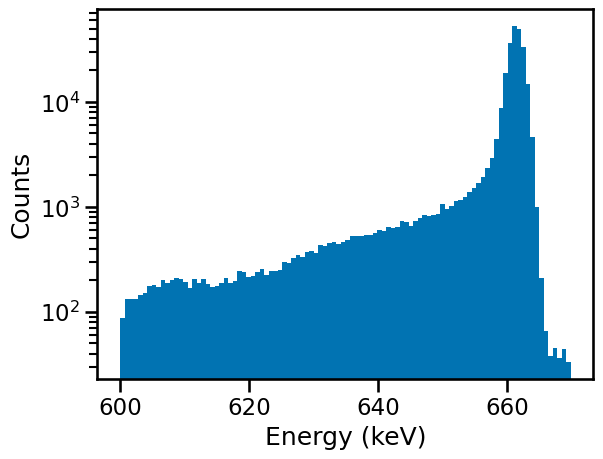

FWHM = 2.73
FWTM = 5.32


In [2]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]

emin = 600.
emax = 670.
    
## Read in the dat files
fullpaths = []
for p in allpaths:
    fullpaths.append(datpath + 'preLL/' + p)

df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

plt.figure()
hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

plt.figure()
hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

In [3]:
### Run depth calibration

ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

eratio_map = [[[] for p in range(37)] for n in range(37)]
eratio_flat = []
depth_map = [[[] for p in range(37)] for n in range(37)]
depth_flat = []
depth_err_map = [[[] for p in range(37)] for n in range(37)]
depth_err_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                   df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                  df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
        ctd_obs_map[p][n] = ctd_obs[~bad]
        ctd_stretch_map[p][n] = ctd_stretch[~bad]
        ctd_obs_flat.append(ctd_obs[~bad])
        ctd_stretch_flat.append(ctd_stretch[~bad])
        eratio = np.array(df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'].values/df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n'].values)
        # print(eratio[0])
        
        eratio_map[p][n] = eratio[~bad]
        eratio_flat.append(eratio[~bad])
        depth_map[p][n] = depth[~bad]
        depth_flat.append(depth[~bad])
        depth_err_map[p][n] = depth_err[~bad]
        depth_err_flat.append(depth_err[~bad])

ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)

eratio_flat = np.concatenate(eratio_flat)
depth_flat = np.concatenate(depth_flat)
depth_err_flat = np.concatenate(depth_err_flat)

[1.00584024 4.66024807 0.20000003]
[0.01316291 4.56225989 5.40970766]
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.111e+07 (chi2/ndof = 340.5)│              Nfcn = 568              │
│ EDM = 224 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────

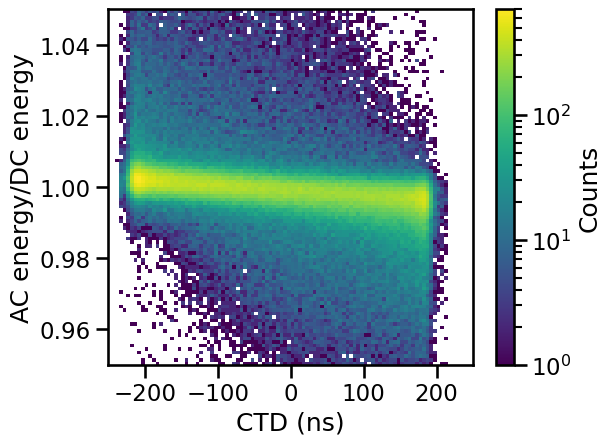

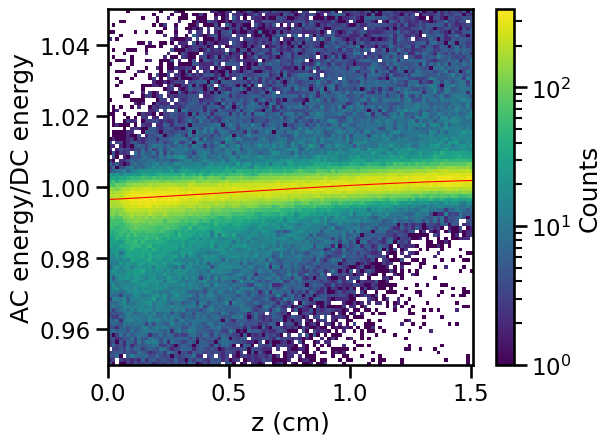

In [4]:
popt, pcov = curve_fit(depth_to_eratio, depth_flat, eratio_flat, sigma = 0.004*np.ones(eratio_flat.shape),\
                       p0=p0, bounds=([0.9,1.0,0.2], [1.1,10.,50.]))
print(popt)
print(np.sqrt(np.diag(pcov)))

c = cost.LeastSquares(depth_flat, eratio_flat, 0.004*np.ones(eratio_flat.shape), depth_to_eratio)
m = Minuit(c, ae_over_ah=662.411/662.114, b=1.3, c=0.5)
m.limits['b', 'c'] = [0.1, 100.]
m.limits['ae_over_ah'] = [0.5, 2.0]
m.migrad()
m.hesse()
print(m)

eratio_plot = np.linspace(0.9,1.1, num=300)  
depth_plot = np.linspace(0.0,1.51, num=300)    

plt.figure()
plt.hist2d(ctd_stretch_flat, eratio_flat, bins=100, range=[[-250, 250], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('CTD (ns)')
plt.ylabel('AC energy/DC energy')
plt.tight_layout()
plt.savefig(plot_dir + 'CTD_to_eratio_preLL_Cs137.pdf')
plt.show()

plt.figure()
plt.hist2d(depth_flat, eratio_flat, bins=100, range=[[0.0, 1.51], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.plot(depth_plot, depth_to_eratio(depth_plot, *p0), color='red', lw=0.8)
# plt.plot(depth_plot, depth_to_eratio(depth_plot, *popt), color='yellow', lw=0.8)
plt.colorbar(label='Counts')
plt.ylabel('AC energy/DC energy')
plt.xlabel('z (cm)')
plt.tight_layout()
plt.savefig(plot_dir + 'depth_to_eratio_preLL_Cs137.pdf')
plt.show()


# z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

# Ba133 

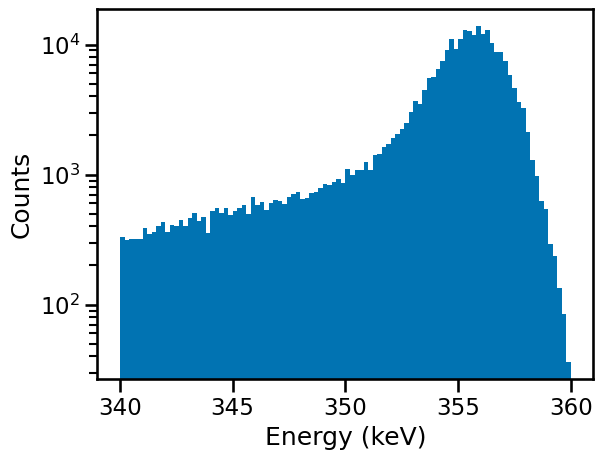

FWHM = 2.98
FWTM = 6.99


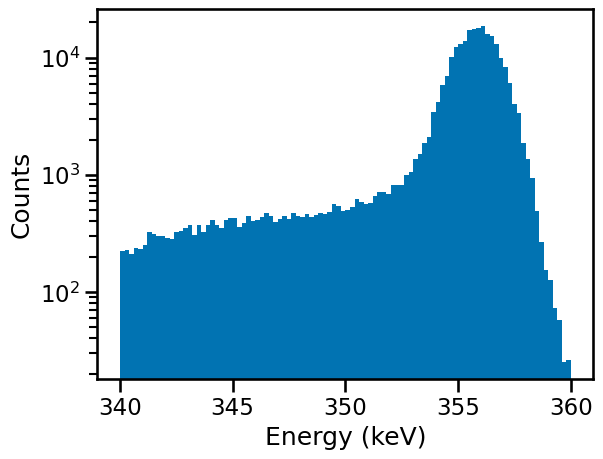

FWHM = 2.32
FWTM = 4.42


In [5]:
AC_list = ['20231005_Ba133_AC_600V.dat']
DC_list = ['20231006_Ba133_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]

emin = 340.
emax = 360.
    
## Read in the dat files
fullpaths = []
for p in allpaths:
    fullpaths.append(datpath + 'preLL/' + p)

df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

plt.figure()
hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

plt.figure()
hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

In [6]:
### Run depth calibration

ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

eratio_map = [[[] for p in range(37)] for n in range(37)]
eratio_flat = []
depth_map = [[[] for p in range(37)] for n in range(37)]
depth_flat = []
depth_err_map = [[[] for p in range(37)] for n in range(37)]
depth_err_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                   df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                  df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
        ctd_obs_map[p][n] = ctd_obs[~bad]
        ctd_stretch_map[p][n] = ctd_stretch[~bad]
        ctd_obs_flat.append(ctd_obs[~bad])
        ctd_stretch_flat.append(ctd_stretch[~bad])
        eratio = np.array(df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'].values/df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n'].values)
        # print(eratio[0])
        
        eratio_map[p][n] = eratio[~bad]
        eratio_flat.append(eratio[~bad])
        depth_map[p][n] = depth[~bad]
        depth_flat.append(depth[~bad])
        depth_err_map[p][n] = depth_err[~bad]
        depth_err_flat.append(depth_err[~bad])

ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)

eratio_flat = np.concatenate(eratio_flat)
depth_flat = np.concatenate(depth_flat)
depth_err_flat = np.concatenate(depth_err_flat)

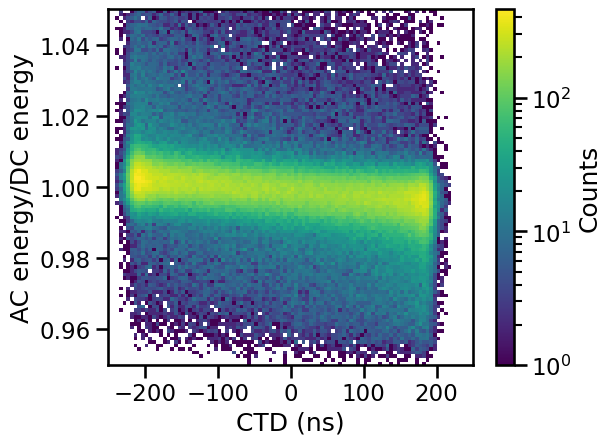

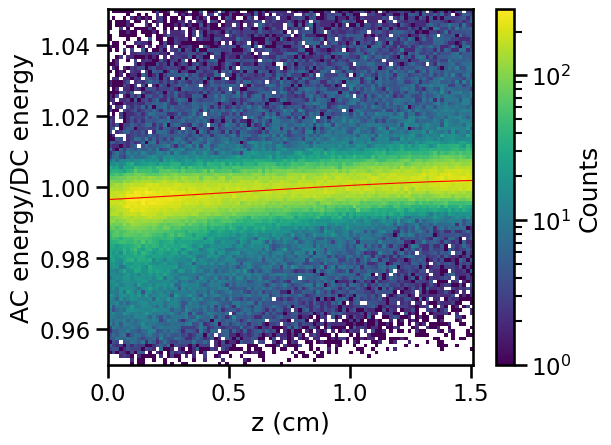

In [7]:
# popt, pcov = curve_fit(depth_to_eratio, depth_flat, eratio_flat, sigma = 0.004*np.ones(eratio_flat.shape),\
#                        p0=p0, bounds=([0.9,1.0,0.2], [1.1,10.,50.]))
# print(popt)
# print(np.sqrt(np.diag(pcov)))

eratio_plot = np.linspace(0.9,1.1, num=300)  
depth_plot = np.linspace(0.0,1.51, num=300)    

plt.figure()
plt.hist2d(ctd_stretch_flat, eratio_flat, bins=100, range=[[-250, 250], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('CTD (ns)')
plt.ylabel('AC energy/DC energy')
plt.tight_layout()
plt.savefig(plot_dir + 'CTD_to_eratio_preLL_Ba133.pdf')
plt.show()

plt.figure()
plt.hist2d(depth_flat, eratio_flat, bins=100, range=[[0.0, 1.51], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.plot(depth_plot, depth_to_eratio(depth_plot, *p0), color='red', lw=0.8)
# plt.plot(depth_plot, depth_to_eratio(depth_plot, *popt), color='yellow', lw=0.8)
plt.colorbar(label='Counts')
plt.ylabel('AC energy/DC energy')
plt.xlabel('z (cm)')
plt.tight_layout()
plt.savefig(plot_dir + 'depth_to_eratio_preLL_Ba133.pdf')
plt.show()


# z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

# Am241

In [6]:
AC_list = ['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat']
DC_list = ['20230922_Am241_DC_600V_1.dat', '20230922_Am241_DC_600V_2.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]

emin = 50.
emax = 62.
    
## Read in the dat files
fullpaths = []
for p in allpaths:
    fullpaths.append(datpath + 'preLL/' + p)

df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

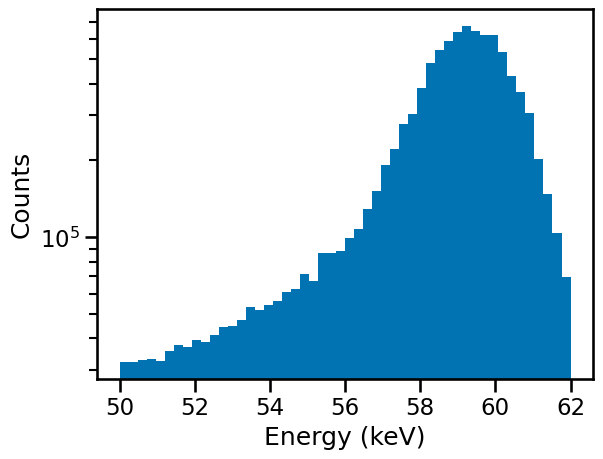

FWHM = 2.92
FWTM = 0.37


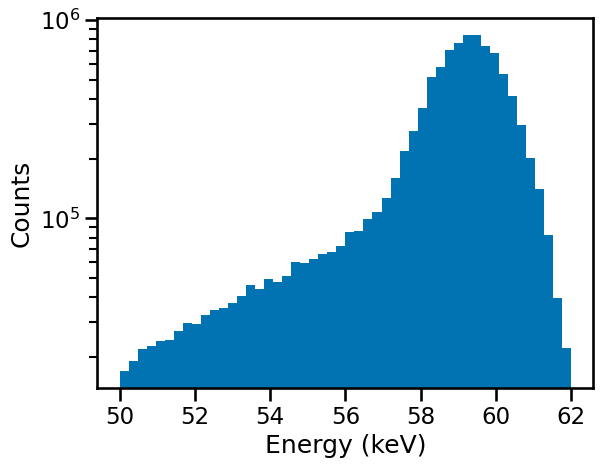

FWHM = 2.31
FWTM = 5.32


In [7]:
plt.figure()
hist,binedges,_  = plt.hist(df['energy_p'], bins=50)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

plt.figure()
hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

In [8]:
### Run depth calibration

ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

eratio_map = [[[] for p in range(37)] for n in range(37)]
eratio_flat = []
depth_map = [[[] for p in range(37)] for n in range(37)]
depth_flat = []
depth_err_map = [[[] for p in range(37)] for n in range(37)]
depth_err_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                   df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                  df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
        ctd_obs_map[p][n] = ctd_obs[~bad]
        ctd_stretch_map[p][n] = ctd_stretch[~bad]
        ctd_obs_flat.append(ctd_obs[~bad])
        ctd_stretch_flat.append(ctd_stretch[~bad])
        eratio = np.array(df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'].values/df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n'].values)
        # print(eratio[0])
        
        eratio_map[p][n] = eratio[~bad]
        eratio_flat.append(eratio[~bad])
        depth_map[p][n] = depth[~bad]
        depth_flat.append(depth[~bad])
        depth_err_map[p][n] = depth_err[~bad]
        depth_err_flat.append(depth_err[~bad])

ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)

eratio_flat = np.concatenate(eratio_flat)
depth_flat = np.concatenate(depth_flat)
depth_err_flat = np.concatenate(depth_err_flat)

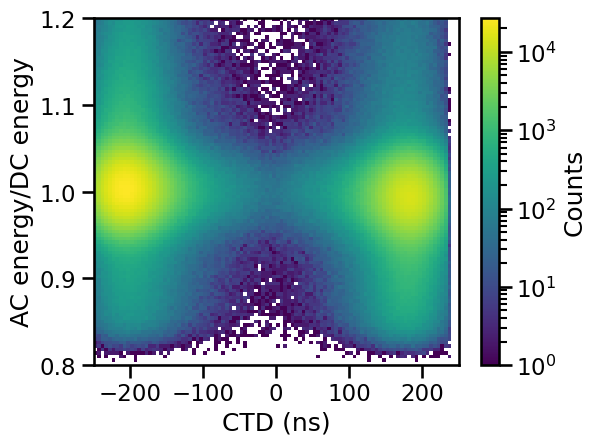

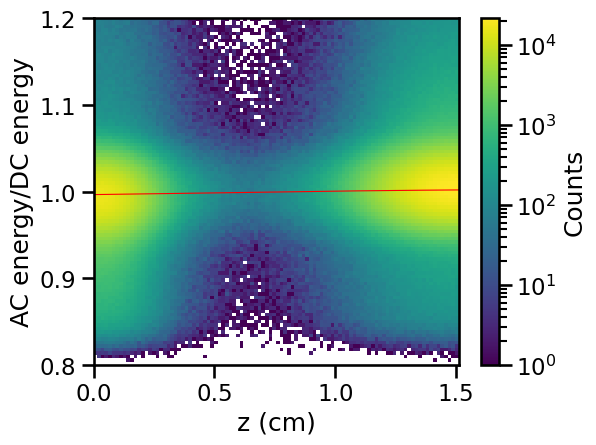

In [10]:
# popt, pcov = curve_fit(depth_to_eratio, depth_flat, eratio_flat, sigma = 0.004*np.ones(eratio_flat.shape),\
#                        p0=p0, bounds=([0.9,1.0,0.2], [1.1,10.,50.]))
# print(popt)
# print(np.sqrt(np.diag(pcov)))

eratio_plot = np.linspace(0.9,1.1, num=300)  
depth_plot = np.linspace(0.0,1.51, num=300)    

plt.figure()
plt.hist2d(ctd_stretch_flat, eratio_flat, bins=100, range=[[-250, 250], [0.8, 1.2]], norm=mpl.colors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('CTD (ns)')
plt.ylabel('AC energy/DC energy')
plt.tight_layout()
plt.savefig(plot_dir + 'CTD_to_eratio_preLL_Am241.pdf')
plt.show()

plt.figure()
plt.hist2d(depth_flat, eratio_flat, bins=100, range=[[0.0, 1.51], [0.8, 1.2]], norm=mpl.colors.LogNorm())
plt.plot(depth_plot, depth_to_eratio(depth_plot, *p0), color='red', lw=0.8)
# plt.plot(depth_plot, depth_to_eratio(depth_plot, *popt), color='yellow', lw=0.8)
plt.colorbar(label='Counts')
plt.ylabel('AC energy/DC energy')
plt.xlabel('z (cm)')
plt.tight_layout()
plt.savefig(plot_dir + 'depth_to_eratio_preLL_Am241.pdf')
plt.show()


# z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

# Na22

In [2]:
AC_list = ['20231024_Na22_AC_600V_1.dat', '20231024_Na22_AC_600V_2.dat', '20231026_Na22_AC_600V.dat']
DC_list = ['20231024_Na22_DC_600V.dat', '20231025_Na22_DC_600V_1.dat', '20231025_Na22_DC_600V_2.dat', '20231026_Na22_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]

emin = 1250.
emax = 1278.
    
## Read in the dat files
fullpaths = []
for p in allpaths:
    fullpaths.append(datpath + 'preLL/' + p)

df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

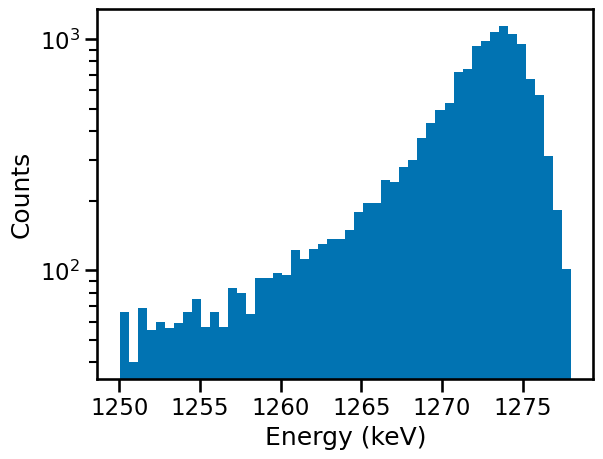

FWHM = 7.14
FWTM = 26.7


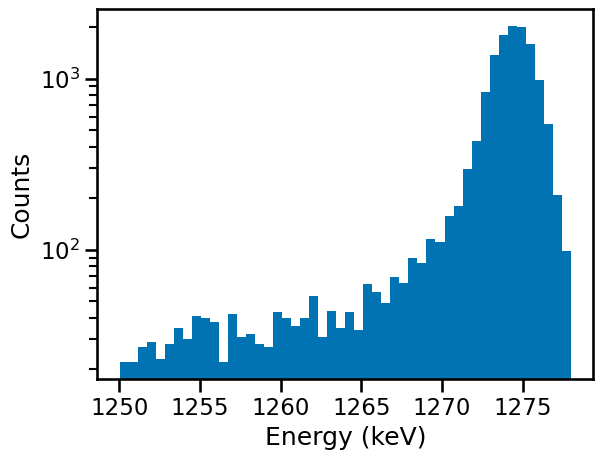

FWHM = 3.15
FWTM = 6.03


In [3]:
plt.figure()
hist,binedges,_  = plt.hist(df['energy_p'], bins=50)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

plt.figure()
hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
print('FWHM = ' + str(round(fwhm, 2)))
print('FWTM = ' + str(round(fwtm, 2)))

In [4]:
### Run depth calibration

ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

eratio_map = [[[] for p in range(37)] for n in range(37)]
eratio_flat = []
depth_map = [[[] for p in range(37)] for n in range(37)]
depth_flat = []
depth_err_map = [[[] for p in range(37)] for n in range(37)]
depth_err_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                   df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                  df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
        ctd_obs_map[p][n] = ctd_obs[~bad]
        ctd_stretch_map[p][n] = ctd_stretch[~bad]
        ctd_obs_flat.append(ctd_obs[~bad])
        ctd_stretch_flat.append(ctd_stretch[~bad])
        eratio = np.array(df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'].values/df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n'].values)
        # print(eratio[0])
        
        eratio_map[p][n] = eratio[~bad]
        eratio_flat.append(eratio[~bad])
        depth_map[p][n] = depth[~bad]
        depth_flat.append(depth[~bad])
        depth_err_map[p][n] = depth_err[~bad]
        depth_err_flat.append(depth_err[~bad])

ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)

eratio_flat = np.concatenate(eratio_flat)
depth_flat = np.concatenate(depth_flat)
depth_err_flat = np.concatenate(depth_err_flat)

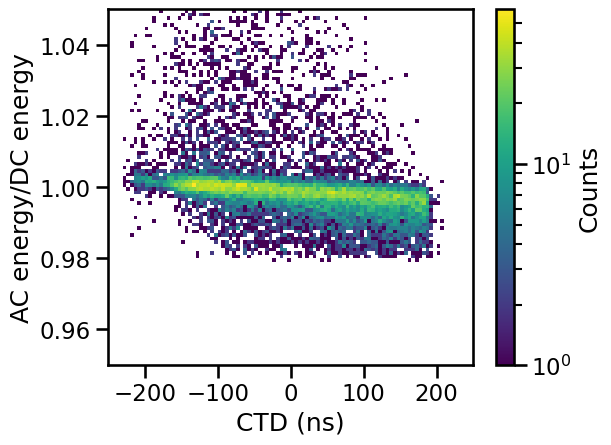

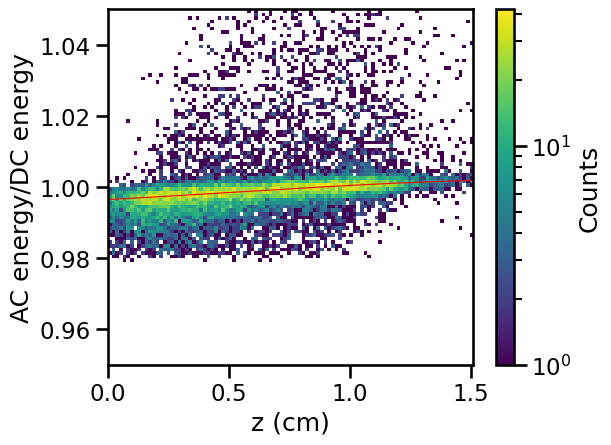

In [5]:
# popt, pcov = curve_fit(depth_to_eratio, depth_flat, eratio_flat, sigma = 0.004*np.ones(eratio_flat.shape),\
#                        p0=p0, bounds=([0.9,1.0,0.2], [1.1,10.,50.]))
# print(popt)
# print(np.sqrt(np.diag(pcov)))

eratio_plot = np.linspace(0.9,1.1, num=300)  
depth_plot = np.linspace(0.0,1.51, num=300)    

plt.figure()
plt.hist2d(ctd_stretch_flat, eratio_flat, bins=100, range=[[-250, 250], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('CTD (ns)')
plt.ylabel('AC energy/DC energy')
plt.tight_layout()
plt.savefig(plot_dir + 'CTD_to_eratio_preLL_Na22.pdf')
plt.show()

plt.figure()
plt.hist2d(depth_flat, eratio_flat, bins=100, range=[[0.0, 1.51], [0.95, 1.05]], norm=mpl.colors.LogNorm())
plt.plot(depth_plot, depth_to_eratio(depth_plot, *p0), color='red', lw=0.8)
# plt.plot(depth_plot, depth_to_eratio(depth_plot, *popt), color='yellow', lw=0.8)
plt.colorbar(label='Counts')
plt.ylabel('AC energy/DC energy')
plt.xlabel('z (cm)')
plt.tight_layout()
plt.savefig(plot_dir + 'depth_to_eratio_preLL_Na22.pdf')
plt.show()


# z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [8]:
np.sum(np.isnan(depth_flat))

2